# Example Avionics model with the following goals:
**GOALS:**
1. [x] Create 2 "LRUs" that can talk to each other over a serial bus connection
    - [ ] this bus connection must have a data throughput constraint of 1 Mb/s
    - [x] The LRU's need to have attributes such as cpu_percent_used, ram_percent_used, and percent non-volatile memory used.
2. [x] Add at least 2 data elements that flow over this serial bus connection 
    - [x] each data element needs to have 2 attributes defined: data size and data rate
3. [x] Create a dependent variable in the interface port or on the serial bus that calculates the data throughput of the serial bus given the data elements flowing across it.
    - [ ] verify that it gets calculated by printing out the dependent variable
4. [ ] Create an 'algorithm' part that is inside of one of the LRUs that has the following attributes:
    - [ ] cpu usage (%)
    - [ ] ram usage (%)
    - [ ] execution time (ms)
5. [ ] The Algorithm must use data from the LRU port input and add it's output to the LRU port output.
6. [ ] From a python environment:
    - [ ] set the algorithm attributes by reading one of the pre-trained ML model cards
    - [ ] set the data element attributes by reading another file or hard-coded definition of the data.
7. [ ] Create a new project repo in the postgres db

## Create a library to call from

In [12]:
package AvionicsDataLibrary {
    
    import ScalarValues::Integer;    
    import ScalarValues::Real;
    import ISQInformation::*;
    import ISQ::*;
    import NumericalFunctions::*;

    attribute def DataThroughput :> ScalarValues::Real; //bits per second
    attribute def DataSize :> ScalarValues::Integer; //bits
    enum def RateGroups :>  ScalarValues::Integer {
        enum = 1;
        enum = 2;
        enum = 4;
        enum = 8;
        enum = 16;
    } // Hz
    //attribute def DataRate :> ScalarValues::Integer;
    
    
    //
    item def DataElement {
        attribute dataSize : DataSize;
        attribute dataRate : RateGroups;
        //attribute throughput : DataThroughput;
        attribute throughput = dataSize * dataRate;
        //attribute :>> throughput = dataSize * dataRate;
        
    }
    //defining the dependent variable 'throughput'
    item def CompositeData :> DataElement {
        item subElements : DataElement[1..*];
        
        attribute totalThroughput = throughput + sum(subElements.throughput);
        
    }
    
    
    //item compositeData : CompositeData {
    //    attribute :>> throughput = sum(subcomponents.throughput); 
    //}
        
     

}


Package AvionicsDataLibrary (810e457a-c9d1-4bdb-ba62-392f9e75e765)


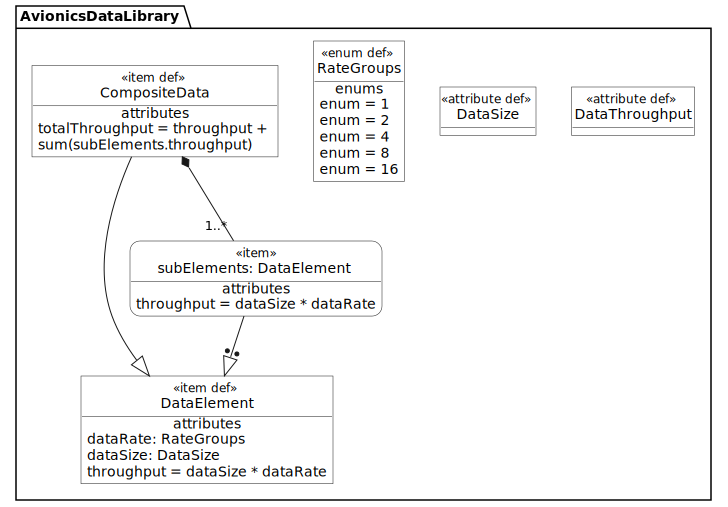

In [13]:
%viz --view=tree AvionicsDataLibrary

In [45]:
package AvionicsHWLibrary {
    
    import AvionicsDataLibrary::*;
    import ScalarValues::Integer;    
    import ScalarValues::Real;
    import NumericalFunctions::*;

    attribute def BusCapacity :> ScalarValues::Integer;
    attribute def Percent :> ScalarValues::Real;
    
    //The port only specifies the interaction point. 
    port def SerialBusPort {
        out item  dataOut : CompositeData;
        in  item  dataIn  : CompositeData;
    }
    
    //composite port on the Mission Computer
    port def CompositePort {
        port serialBusPort:SerialBusPort[2..*];
    }

    //The interface defines the connection between interaction points. 
    interface def SerialBusInterface {
        attribute throughput : DataThroughput;
        attribute maxThroughput : DataThroughput;
        end supplierPort : SerialBusPort;
        end consumerPort : ~SerialBusPort;
        
    }
        
        
    //define the typical HW device
    part def EmbeddedDevice {
        attribute percentCPU_Used : Percent;
        attribute percentVolitileMemoryUsed : Percent;
        attribute percentNonVolitileMemoryUsed : Percent;
        port ports : SerialBusPort[1..*];
    }
    part ComputeDevice : EmbeddedDevice{
        port compositePort redefines ports : CompositePort[1..*];
    }

    part SensorDevice : EmbeddedDevice{
        port redefines ports : ~SerialBusPort;
    }
 
}

Package AvionicsHWLibrary (f6f9eb5e-a934-4d33-95ae-b1c93b794eff)


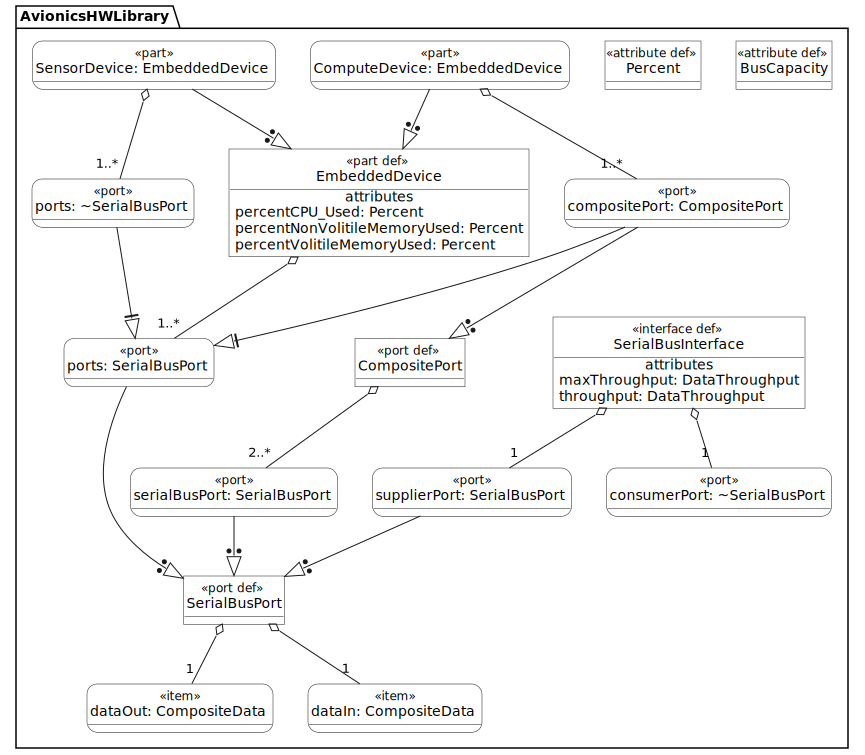

In [46]:
%viz --view=tree AvionicsHWLibrary

In [47]:
package NasaDataModel {
    import AvionicsDataLibrary::*;
    
    item pressure : DataElement {
        redefines dataSize = 16 ;
        redefines dataRate = 2;
    }
    item temp : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 1;
    }
    
    // Actual Nasa data elements
    item Time : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 16;
    }  
    item FPAC : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 16;
    }
    item BLAC : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 16;
    }
    item CTAC : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 16;
    }
    item VRTG : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 8;
    }
    item LATG : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 4;
    }
    item LONG : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 4;
    }
    item RALT : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 8;
    }
    item ALTR : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 4;
    }
    item IVV : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 16;
    }
    item VSPS : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 1;
    }
    item PSA : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 2;
    }
    item PI : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 2;
    }
    item PT : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 2;
    }
    item TAS : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 4;
    }
    item CAS : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 4;
    }
    item GS : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 4;
    }
    item WS : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 4;
    }
    item CASS : DataElement {
        redefines dataSize = 16;
        redefines dataRate = 1;
    }
    item PTCH : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 8;
    }
    item ROLL : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 8;
    }
    item DA : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 4;
    }
    item TAT : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 1;
    }
    item SAT : DataElement {
        redefines dataSize = 8;
        redefines dataRate = 1;
    }
    item LATP : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 1;
    }
    item LONP : DataElement {
        redefines dataSize = 32;
        redefines dataRate = 1;
    }
}

Package NasaDataModel (660e2e7f-9e52-4f85-9e87-239179722d36)


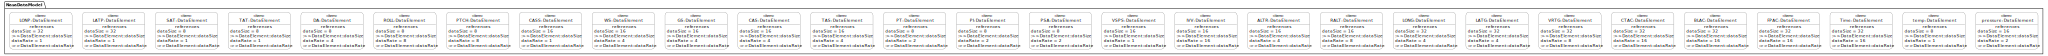

In [28]:
//import NasaDataModel
%viz --view=tree NasaDataModel

In [67]:
package nasa_avionics {


    import AvionicsDataLibrary::*;
    import AvionicsHWLibrary::*;
    import NasaDataModel::*;

       
    part avionicsSystem {
         
        part MC redefines ComputeDevice {
            //redefine ports
            port mux1 redefines compositePort  {
                //port serialBusPort [4] :>> serialBusPort;
                port cadcPort [1] :> serialBusPort;
                port raltPort [1] :> serialBusPort;
                port insPort [1]  :> serialBusPort;
                port gpsPort [1]  :> serialBusPort;
            }
            port mux2 redefines compositePort  {
                //port serialBusPort [4] :>> serialBusPort;
                port pfcPort [1] :> serialBusPort;
                port mfdPort [1] :> serialBusPort;
                port insPort [1] :> serialBusPort;
                port gpsPort [1] :> serialBusPort;
            }
                
             
        }
        
        //congugate the port on the otherside.
        part CADC :>> SensorDevice {
            port mux1[1] :> ports;
        }
        part RALT :>> SensorDevice {
            port mux1[1] :> ports;
        }
        part INS :>> SensorDevice {
            port mux1[1] :> ports;
            port mux2[1] :> ports;
        }
        part GPS :>> SensorDevice {
            port mux1[1] :> ports;
            port mux2[1] :> ports;
        }
        part PFC :>> SensorDevice {
            port mux2[1] :> ports;
        }
        part MFD :>> SensorDevice {
            port mux2[1] :> ports;
        }
             
        //   MUX1 interfaces
        interface cadc_IF : SerialBusInterface connect
            supplierPort ::> MC.mux1.cadcPort to 
            consumerPort ::> CADC.mux1;
        interface ralt_IF : SerialBusInterface connect
            supplierPort ::> MC.mux1.raltPort to 
            consumerPort ::> RALT.mux1;
        interface ins1_IF : SerialBusInterface connect
            supplierPort ::> MC.mux1.insPort to 
            consumerPort ::> INS.mux1;
        interface gps1_IF : SerialBusInterface connect
            supplierPort ::> MC.mux1.gpsPort to 
            consumerPort ::> GPS.mux1;
        
        //   MUX2 interfaces
        interface pfc_IF : SerialBusInterface connect
            supplierPort ::> MC.mux2.pfcPort to 
            consumerPort ::> PFC.mux2;
        interface MFD_IF : SerialBusInterface connect
            supplierPort ::> MC.mux2.mfdPort to 
            consumerPort ::> MFD.mux2;
        interface ins2_IF : SerialBusInterface connect
            supplierPort ::> MC.mux2.insPort to 
            consumerPort ::> INS.mux2;
        interface gps2_IF : SerialBusInterface connect
            supplierPort ::> MC.mux2.gpsPort to 
            consumerPort ::> GPS.mux2;
    }
}

Package nasa_avionics (43608428-3981-45b3-ac9f-487e1ce9eda6)


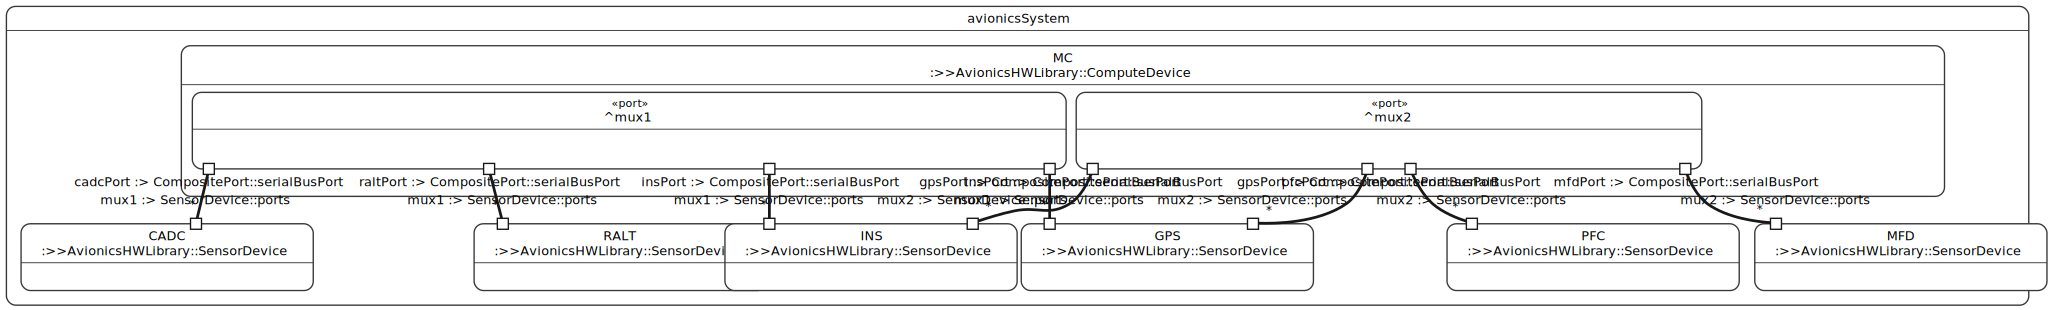

In [68]:
%viz --view=interconnection nasa_avionics::avionicsSystem

In [ ]:
//use this to bind connectors through the mux busses.
// i may need to use nested ports on the MC main ports.

package 'Binding Connectors Example-1' {
	import 'Port Example'::*;
	
	part def Vehicle;
	part def FuelPump;
	part def FuelTank;
	
	part vehicle : Vehicle {	
		part tank : FuelTankAssembly {
			port redefines fuelTankPort {
				out item redefines fuelSupply;
				in item redefines fuelReturn;
			}
			
			bind fuelTankPort.fuelSupply = pump.pumpOut;
			bind fuelTankPort.fuelReturn = tank.fuelIn;
			
			part pump : FuelPump {
				out item pumpOut : Fuel;
				in item pumpIn : Fuel;
			}
			
			part tank : FuelTank {
				out item fuelOut : Fuel;
				in item fuelIn : Fuel;
			}
		}
	} 
}

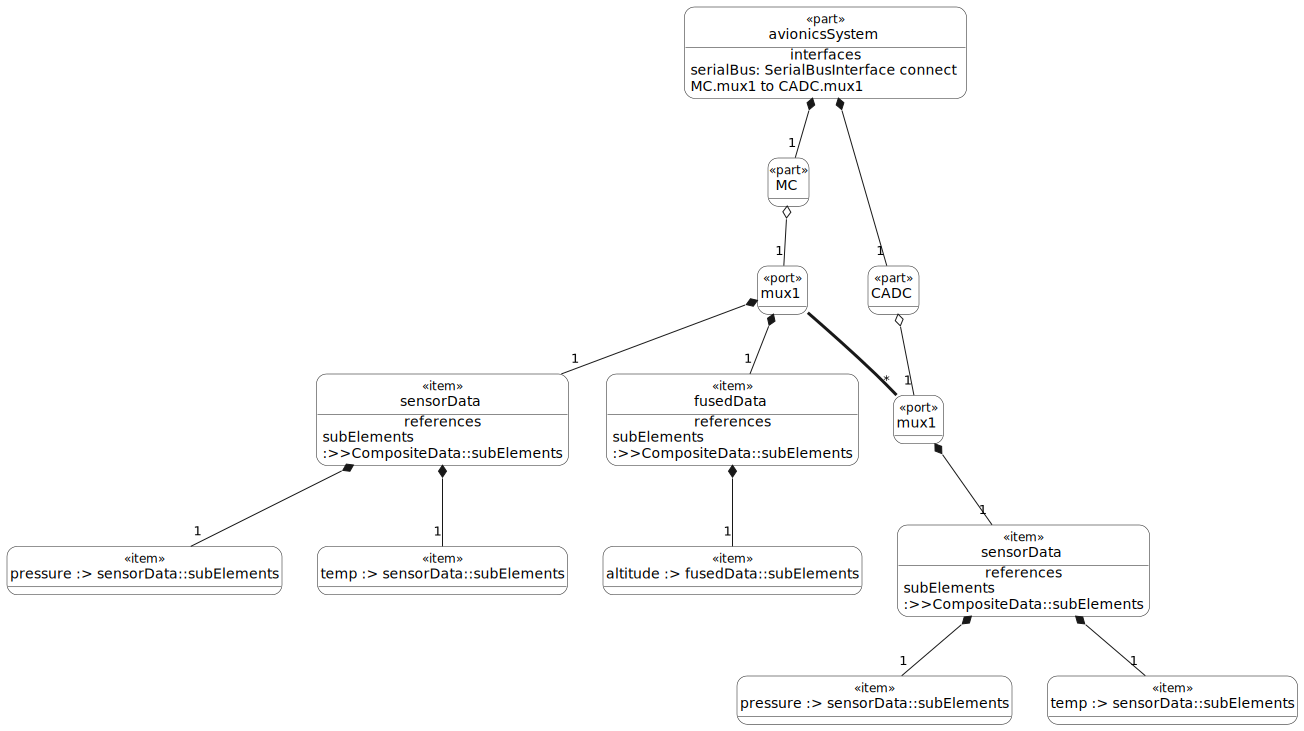

In [164]:
%viz --view=tree nasa_avionics::avionicsSystem

In [154]:
package SimpleAvionicsModel {


    import AvionicsDataLibrary::*;
    import AvionicsHWLibrary::*;
    import NasaDataModel::*;

       
    part AvionicsSystem {
         
        part busController redefines ComputeDevice {
            //redefine ports
            port bcPort1[1] redefines ports  {
                item sensorData redefines dataIn {
                    subElements[2] redefines subElements;
                    // subsets and :> are the equivalent
                    item pressure[1] subsets subElements;
                    item temp[1] :> subElements;
                }
                // redefines and :>> are equivalent
                item fusedData :>> dataOut {
                    subElements[1] redefines subElements;
                    item altitude[1] :> subElements;
                }
            } 
        }
        
        //congugate the port on the otherside.
        part sensor1 :>> SensorDevice {
            port sensor1Port1[1] :>> ports {
                item sensorData :>> dataOut {
                    subElements[2] :>> subElements;
                    item pressure[1] :> subElements;
                    item temp[1] :> subElements;
                }
            }
        }
        
        
        interface serialBus : SerialBusInterface connect
            supplierPort ::> busController.bcPort1 to 
            consumerPort ::> sensor1.sensor1Port1;
    }
}

Package SimpleAvionicsModel (78a3cb49-d817-4fd5-b606-5e381b02da40)


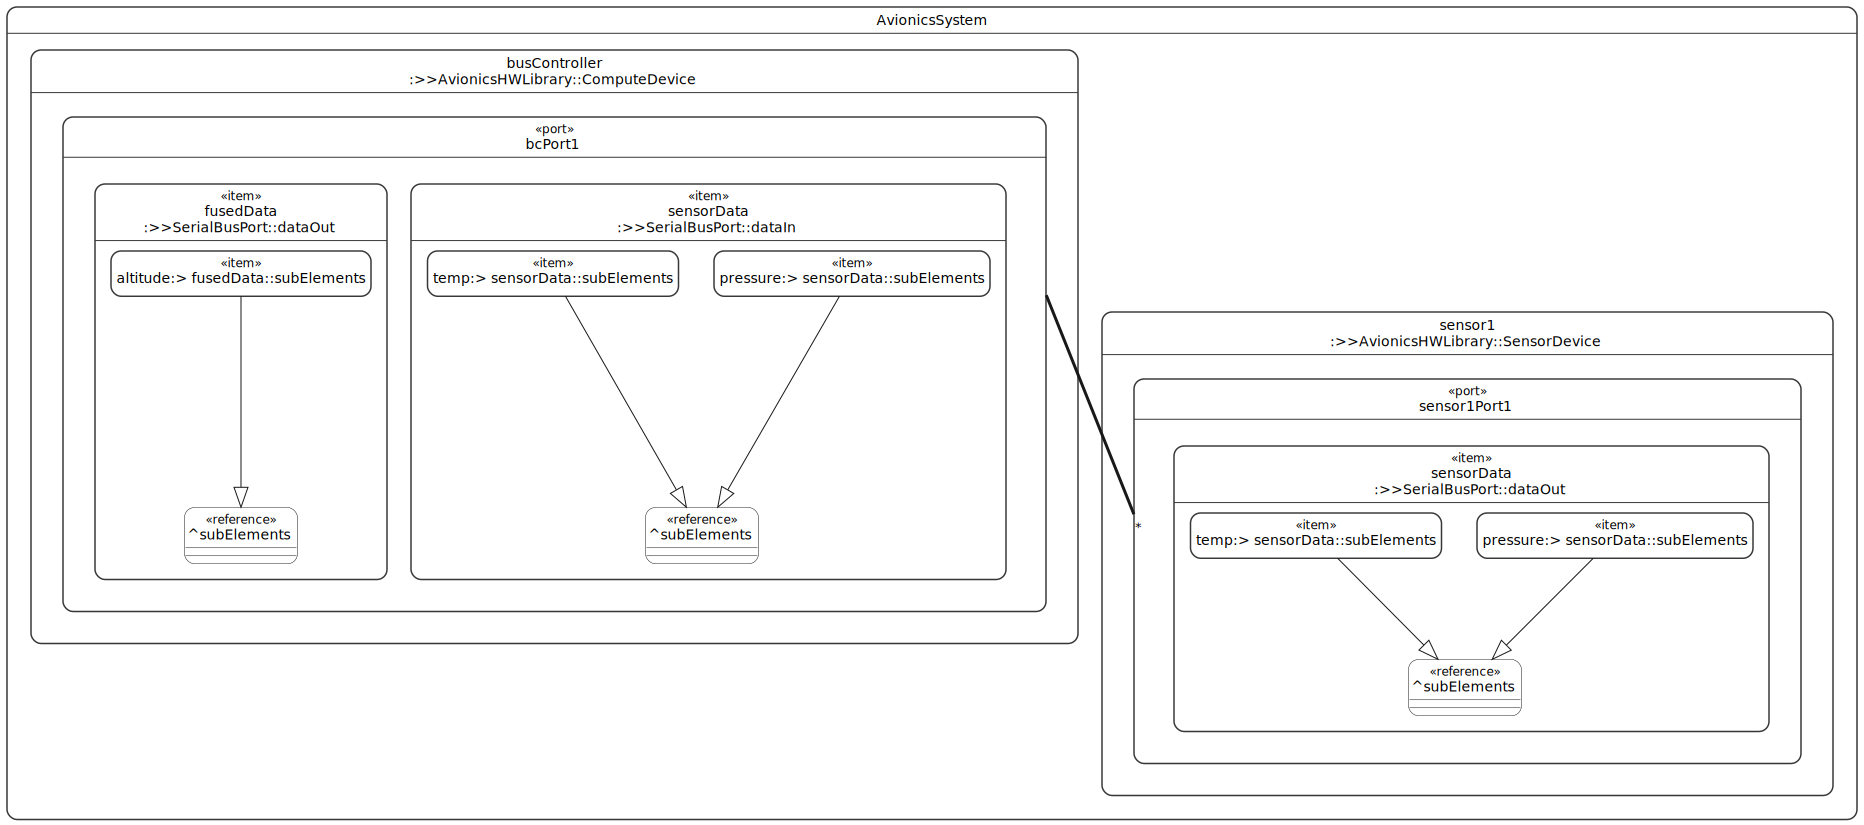

In [155]:
%viz --view=interconnection SimpleAvionicsModel::AvionicsSystem

In [122]:
package NASA_AvionicsModel {


    import SimpleAvionicsModel::*;

    part nasa :> AvionicsSystem {
        
        part bc :>> busController {
            //attribute :>> percentCPU_Used = 50%;
            //attribute :>> percentRAM_Used = 78.2%;
            //attribute :>> percentNonVolitileMemoryUsed = 98.5%;
            port Mux1Port:>> bcPort1 {
                //item CADCData :>> sensorData{
                    //item :>> pressure {
                       // attribute :>> dataSize = 8;
                      //  attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.
                    //}
                  //  item :>> temp {
                    //    attribute :>> dataSize = 10;
                      //  attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.                    
                    //}
                //}
                item :>> fusedData {
                    item :>> altitude {
                        attribute :>> dataSize = 16;
                        attribute :>> dataRate = 50;
                        //throughput should be derived from the attributes above.
                    }
                }
            }
        }
        part CADC :>> sensor1 {
            //attribute :>> percentCPU_Used = 50%;
            //attribute :>> percentRAM_Used = 78.2%;
            //attribute :>> percentNonVolitileMemoryUsed = 98.5%;
            port Mux1Port:>> sensor1Port1 {
                item CADCData :>> sensorData{
                   // item :>> pressure {
                    //    attribute :>> dataSize = 8;
                     //   attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.
                    //}
                    item :>> temp {
                        attribute :>> dataSize = 10;
                        attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.                    
                    }
                }
            }
        }
        interface A_MUX :>> serialBus connect
            supplierPort ::> bc.Mux1Port to 
            consumerPort ::> CADC.Mux1Port;
                
    }          
}

Package NASA_AvionicsModel (d9ff5c1e-1d28-4cf1-b68d-754988415080)


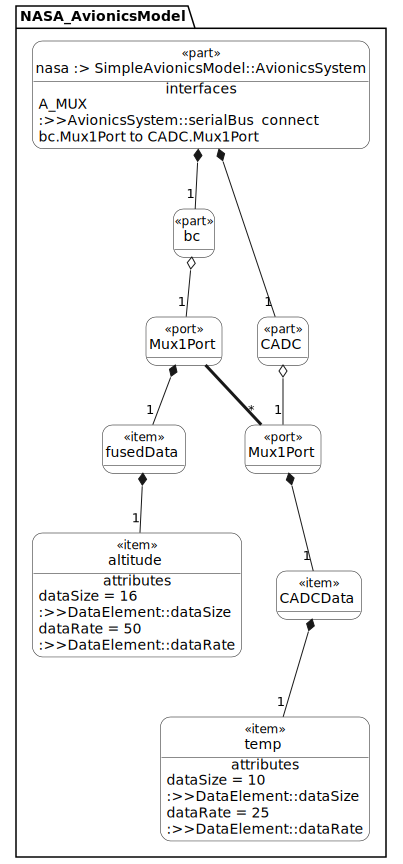

In [123]:
%viz --view=tree NASA_AvionicsModel

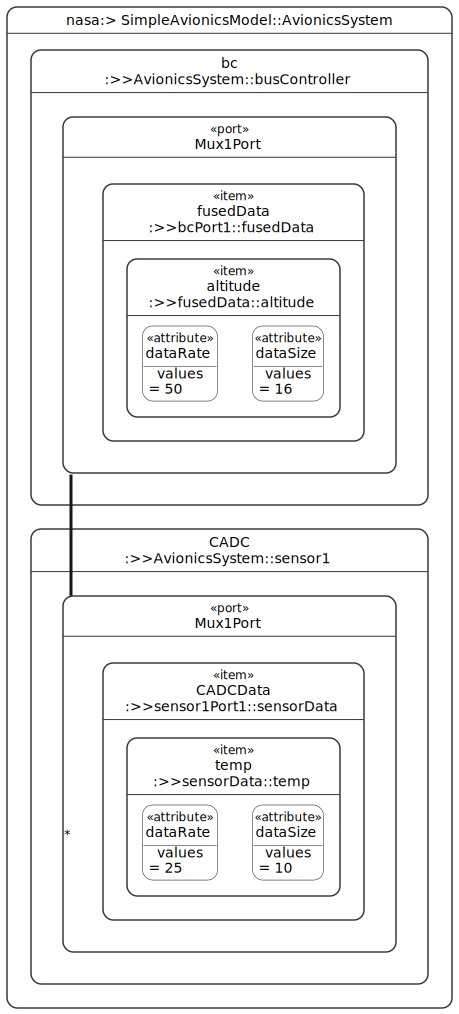

In [127]:
%viz --view=interconnection NASA_AvionicsModel::nasa

## Different ways to visualize the model

Full package view

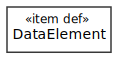

In [45]:
%viz SimpleAvionicsModel::DataElement

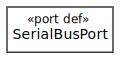

In [46]:
%viz SimpleAvionicsModel::SerialBusPort

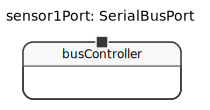

In [49]:
%viz SimpleAvionicsModel::AvionicsSystem::busController